Using Parmest to model PCB and Puromycin

In [2]:
# Installing libraries
import sys
!pip install pyomo
import pyomo
import scipy

if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.8 MB/s eta 0:00:00
--2024-11-06 16:52:10--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-11-06 16:52:10 (77.3 MB/s) - ‘helper.py’ saved [6493/6493]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.6.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *
from pyomo.dae import *

In [10]:
!pip install --upgrade pyomo
!pip install --upgrade pyomo[parmest]
!pip install -U pyomo

In [23]:
import pandas as pd
import pyomo.environ as pyo
import numpy as np
import pyomo.contrib.parmest.parmest as parmest

# Create the DataFrame
data = {
    'Age (years)': [1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 11, 12, 12, 12],
    'PCB Concentration (ppm)': [0.6, 1.6, 0.5, 1.2, 2.0, 1.3, 2.5, 2.2, 2.4, 1.2, 3.5, 4.1, 5.1, 5.7, 3.4, 9.7, 8.6, 4.0, 5.5, 10.5, 17.5, 13.4, 4.5, 30.4, 12.4, 13.4, 26.2, 7.4]
}
df = pd.DataFrame(data)
df['ln_PCB_Concentration'] = np.log(df['PCB Concentration (ppm)'])

# Define the model function
def pyomo_model(data):
    model = pyo.ConcreteModel()
    model.m = pyo.Var(initialize=0)  # Slope
    model.b = pyo.Var(initialize=0)  # Intercept
    model.age = pyo.Param(initialize=data['Age (years)'])
    model.ln_pcb = pyo.Param(initialize=data['ln_PCB_Concentration'])

    def obj_expression(model):
        return (model.ln_pcb - (model.m * model.age + model.b))**2
    model.obj = pyo.Objective(rule=obj_expression, sense=pyo.minimize)
    return model

exp_list = [
    {'Age (years)': row['Age (years)'], 'ln_PCB_Concentration': row['ln_PCB_Concentration']}
    for _, row in df.iterrows()
]

def SSE(model, data):
    return (data['ln_PCB_Concentration'] - (model.m * data['Age (years)'] + model.b))**2


# Pass the model and data separately to the Estimator
pest = parmest.Estimator(pyomo_model, exp_list, ['m', 'b'], obj_function=SSE)

obj, theta = pest.theta_est()

print('theta:\n',theta)

theta:
 m    0.259128
b    0.031472
dtype: float64


Graph & results from PCB notebook


m (slope) = 0.25912823956403186
b (intercept) = 0.03147246971451784
Objective Value = 8.35897789702813

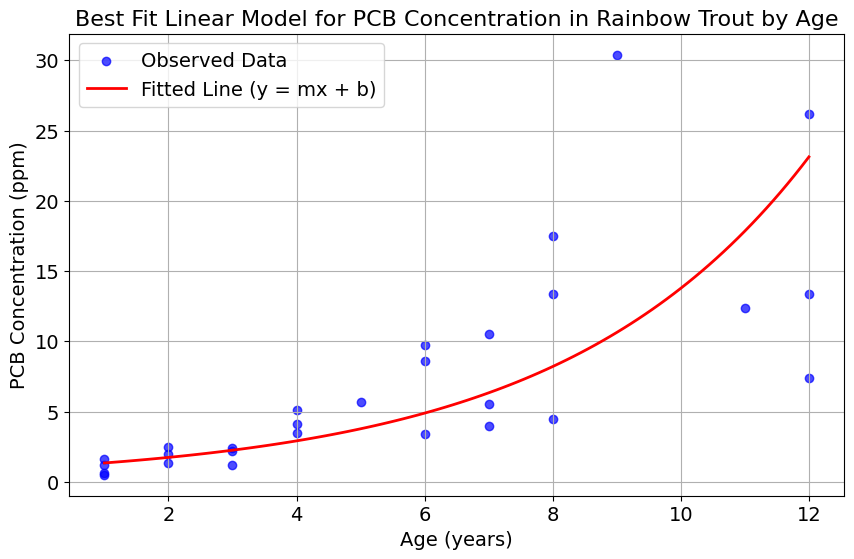





In [27]:
# Should we try and graph the surface expectation?

"import pandas as pd\nimport pyomo.environ as pyo\nimport numpy as np\nimport pyomo.contrib.parmest.parmest as parmest\nimport matplotlib.pyplot as plt  # Import matplotlib for plotting\n\n# ... (Your existing code for data loading and model definition) ...\n\n# Visualizing the parmest data\n\n# Visualizing expectation surface\n# Instead of parmest.plot_theta_surface(pest), you can try visualizing this using matplotlib directly:\ntheta_values = pest.theta_est()\n\n# Generate a grid of parameter values to explore the surface\nm_values = np.linspace(theta_values[1]['m'] - 0.5, theta_values[1]['m'] + 0.5, 50)  # Range for slope\nb_values = np.linspace(theta_values[1]['b'] - 0.5, theta_values[1]['b'] + 0.5, 50)  # Range for intercept\nM, B = np.meshgrid(m_values, b_values)\n\n# Calculate the objective function value for each point on the grid\nZ = np.zeros_like(M)\nfor i in range(M.shape[0]):\n    for j in range(M.shape[1]):\n        # Use the SSE function directly to calculate the objecti

In [34]:
import pandas as pd
import pyomo.environ as pyo
import numpy as np
import pyomo.contrib.parmest.parmest as parmest
import matplotlib.pyplot as plt

# Provided data (made easier to access)
substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
treated_velocity = np.array([[76, 47], [97, 107], [123, 139], [159, 152], [191, 201], [207, 200]])
untreated_velocity = np.array([[67, 51], [84, 86], [98, 115], [131, 124], [144, 158], [160, np.nan]])

# Calculate the average velocities
treated_avg_velocity = np.nanmean(treated_velocity, axis=1)
untreated_avg_velocity = np.nanmean(untreated_velocity, axis=1)

# Define the model function for parmest
def michaelis_menten_model(data):
    model = pyo.ConcreteModel()

    # Parameters
    model.Vmax = pyo.Var(within=pyo.NonNegativeReals, initialize=200)
    model.Km = pyo.Var(within=pyo.NonNegativeReals, initialize=0.1)

    return model


# Prepare the experimental data list for parmest
def prepare_experiment_data(substrate_concentration, velocity_data):
    return [{'substrate_concentration': substrate_concentration[i],
             'velocity': velocity_data[i]} for i in range(len(substrate_concentration))]

# Create experiment list for treated and untreated data
treated_exp_list = prepare_experiment_data(substrate_concentration, treated_avg_velocity)
untreated_exp_list = prepare_experiment_data(substrate_concentration, untreated_avg_velocity)

# Define SSE function for parmest
'''
def SSE(model, data):
    errors = [(data['velocity'][i] - (model.Vmax * data['substrate_concentration'][i]) /
                (model.Km + data['substrate_concentration'][i]))**2
              for i in range(len(data['substrate_concentration']))]
    return sum(errors)  # Return the sum of squared errors
'''
def SSE(model, data):
    # Calculate the predicted velocity
    predicted_velocity = (model.Vmax * data['substrate_concentration']) / (model.Km + data['substrate_concentration'])

    # Calculate the squared error for the current data point
    error = (data['velocity'] - predicted_velocity)**2

    return error  # Return the squared error for this data point

# Use parmest for parameter estimation
pest_treated = parmest.Estimator(michaelis_menten_model, treated_exp_list, ['Vmax', 'Km'], obj_function=SSE)
pest_untreated = parmest.Estimator(michaelis_menten_model, untreated_exp_list, ['Vmax', 'Km'], obj_function=SSE)

# Estimate parameters
obj_treated, theta_treated = pest_treated.theta_est()
obj_untreated, theta_untreated = pest_untreated.theta_est()

# Output the results
print(f'Treated Model - Vmax: {theta_treated["Vmax"]}, Km: {theta_treated["Km"]}')
print(f'Untreated Model - Vmax: {theta_untreated["Vmax"]}, Km: {theta_untreated["Km"]}')

# Optionally, save the results to a CSV
results = pd.DataFrame

Treated Model - Vmax: 212.6837431754675, Km: 0.06412128172805283
Untreated Model - Vmax: 162.21417000297836, Km: 0.049466794702408085


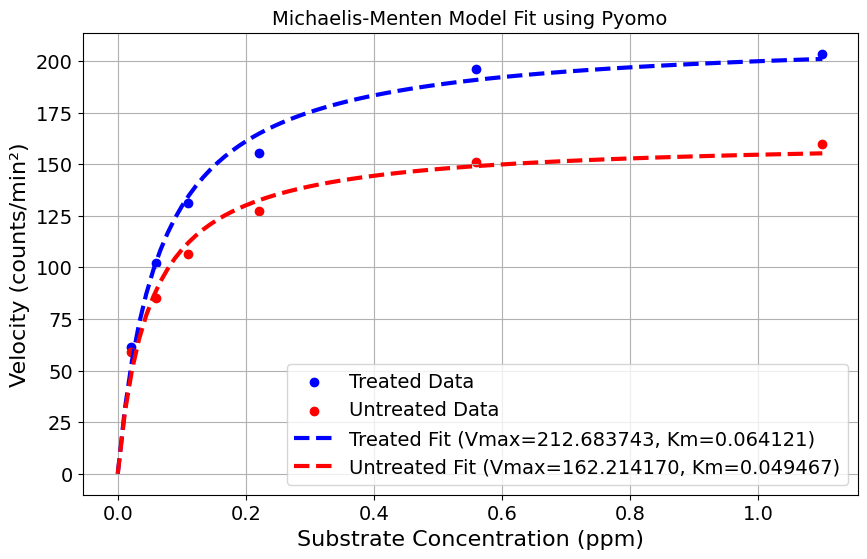![image.png](
  
)

Notes from this:

PCB: Used parmest for a linear equation and got the same answer with manual. I used minimization of SSE as the criterion.

Here is the equation




Questions:
Does Parmest uses ipopt under the hood? If so, how is this different than calling IPOPT by itself?

Did I do this how it was expected to be done?
